# Aggregated data analysis

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import zipfile
import numpy as np
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)


# Local Modules
import sys
import os.path
sys.path.insert(0, os.path.abspath('/scratch/horta/coronawiki/'))
from helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from helpers.vars import helper_langs, interventions_helper, int_c, int_ls
from helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff

In [ ]:
# Latex Configuration
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib as mpl


PARAM = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'text.usetex': True
}

mpl.rcParams.update(PARAM)

In [ ]:
interventions = load_interventions("data/interventions.csv")
topics_df, topics = load_topics('data/topics_linked.csv.xz')
agg = load_aggregated("data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
time_int = 35
dfs_pca_shift = load_pca(codes_order, pca_folder="pca/")

## Video/Games

In [ ]:
number_vg = agg['fr']['topics']['Culture.Media.Video games']['len']
sum_vg = agg['fr']['topics']['Culture.Media.Video games']['sum']
percent_vg = agg['fr']['topics']['Culture.Media.Video games']['percent']

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(agg['fr']["sum"].index,sum_vg, label="Video Game-related articles (fr)")
plt.grid()
plt.legend()
plt.title("Evolution of the view-count of videogame-related articles")
plt.show()

In [ ]:
fig, axs = plt.subplots(12, 2,
                        figsize=(28, 14),
                        sharex=False,
                        gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})

for idx, ax_ in enumerate(axs[:, :]):


    # VIDEO-GAME-RELATED PAGEVIEWS

    ax = ax_[0]
    code = codes_order[idx]
    ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
    ax_twin = ax.twiny()

    start, end = plot_dates(ax, 20200114, 20200731,
                            agg[code]["sum"].index, agg[code]['topics']['Culture.Media.Video games']["sum"].values + agg[code + ".m"]['topics']['Culture.Media.Video games']["sum"].values,
                            color="#377eb8", sci=False)

    plot_dates(ax_twin, 20190114, 20190731, agg[code]["sum"].index,
               agg[code]['topics']['Culture.Media.Video games']["sum"].values + agg[code + ".m"]['topics']['Culture.Media.Video games']["sum"].values,
               adjust=(start, end), sci=False, xticklabels=False, ls=":", color="#377eb8")


    plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    for ax_t in [ax, ax_twin]:
        ax_t.spines['left'].set_visible(False)
        ax_t.spines['top'].set_visible(False)
        ax_t.yaxis.set_ticks_position('right')

    # CUMULATIVE PAGE VIEWS DIFFERENCE

    ax = ax_[1]

    plot_cumm_diff(ax, (20190101, 20191231), [20190115, 20200114], [20190731, 20200729],
                   agg[code]["sum"].index,
                   agg[code]['topics']['Culture.Media.Video games']["sum"].values + agg[code + ".m"]['topics']['Culture.Media.Video games']["sum"].values
                   )

    plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)

    ax.set_ylim([-7.5, 15])
    ax.axhline(0, color="black", alpha=0.3)

    for ax_t in [ax]:
        ax_t.spines['left'].set_visible(False)
        ax_t.spines['top'].set_visible(False)
        ax_t.yaxis.set_ticks_position('right')

    if idx in[0,1,2,3,4,5,6]:
        ax.set_ylim(-50,200)
        ax.set_yticks([0, 100, 200])

    else:
        ax.set_ylim(-9,36)
        ax.set_yticks([0, 18, 36])

    for ax in ax_:
        if idx != 11:
            ax.set_xticklabels([])


axs[0,0].set_title("Number of pageviews not\n related Video-games ", pad=35)
axs[0,1].set_title("Cumulative pageviews difference \n w/ last year (normalized)", pad=35)


lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls=":"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0,0].legend(
    handles=lines,
    labels=["2020", "2019"],
    loc='lower left', bbox_to_anchor=(0.3, 5),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=15
)


lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.)
                for x, _ in interventions_helper.items()]

axs[0,1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v,
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='lower center', bbox_to_anchor=(0.3, 5),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=15
)

# Wikipedia API - Genre specific analysis

This part will
+ Query video-game articles and associated genre from Wikipedia
+ Select genres with more than a chosen amount of instances
+ Extract monthly count-views for each genre, via the Wikipedia API
+ Save the obtained data in the file `video_game_genre2020`
+ Plot values

In [ ]:
#useful imports
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

Let's extract all video-games as well as their genre from Wikipedia

In [ ]:
sparql.setQuery("""
    PREFIX bd: <http://www.bigdata.com/rdf#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

select  ?objet ?objectLabel ?genreLabel ?url
where {
    ?object wdt:P31 wd:Q7889.
    ?object wdt:P136 ?genre.

    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "en" .
    }
}
""")
sparql.setReturnFormat(JSON)
games_result = sparql.query().convert()

In [ ]:
game_genre_df = pd.json_normalize(games_result['results']['bindings'])
game_genre_df

If we count the number of unique genres, we can see there is a lot

In [ ]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

We will consider here that categories with less than 1000 games are not relevant

In [ ]:
test = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()
irr = test[test.values<1000].index
test

Once the genres are chosen, we format the article names to enable the research later on

In [ ]:
game_genre_df = game_genre_df.drop(game_genre_df[game_genre_df['genreLabel.value'].isin(irr)].index)
game_genre_df = game_genre_df.replace(' – ', '', regex=True)
game_genre_df = game_genre_df.replace('°', '', regex=True)
game_genre_df = game_genre_df.replace(' ', '_', regex=True)
game_genre_df = game_genre_df.replace('/', '_', regex=True)

In [ ]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

We can now extract the monthly count-views

In [ ]:
def get_monthly_count(code, name, start_date,end_date):
    '''
    Will return a dataframe of the monthly count-views of an article for the period given and a chosen language
    '''

    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{}.wikipedia/all-access/all-agents/{}/monthly/{}/{}'.format(code,name,start_date,end_date)
    response = urlopen(url)
    data_json = json.loads(response.read())
    df =  pd.json_normalize(data_json['items'])
    return df

In [ ]:
df_action = get_monthly_count('en','Hitman:_Blood_Money','2020010100','2020123100')
dates = df_action.timestamp.tolist()
date = []
for d in dates:
    date.append(datetime.strptime(d, '%Y%m%d%H').strftime('%d/%m/%Y'))
date

Now let's compute views for all genres, WARNING this cell takes a long time to compute

In [ ]:
monthly_views = np.zeros([12,1])

for g in range(len(unique_game_genre_df)):
    names = game_genre_df[game_genre_df['genreLabel.value']==unique_game_genre_df[g]]['objectLabel.value']
    monthly_views_genre = np.zeros([12,1])
    for n in names:
        try:
            df = get_monthly_count('en',n,'2020010100','2020123100')
            df=df.replace(np.nan, 0)
            views = (df.views).array
            views = np.reshape(views,[12,1])
            monthly_views_genre+=views
        except:
            pass
    monthly_views= np.append(monthly_views,monthly_views_genre,axis=1)

In [ ]:
final = monthly_views[:,1:]
df = pd.DataFrame(final, columns = unique_game_genre_df)
df.to_csv('video_game_genre2020.csv')

Finally, let’s plot what we found

In [ ]:
games= pd.read_csv('data/video_game_genre2020.csv')
count = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()

In [ ]:
plt.figure(figsize=(20,10))
for g in count.index:
    plt.plot(dates, games['{}'.format(g)], label='{}'.format(g))

plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

These were absolute view-counts, let’s see relative view-counts taking into consideration the amount of articles per genre.

In [ ]:
for g in count.index:
    games['{}'.format(g)] = games['{}'.format(g)].apply(lambda x: x/count['{}'.format(g)])

games_relative = games

In [ ]:
plt.figure(figsize=(20,10))

for g in count.index:
    plt.plot(dates, games_relative['{}'.format(g)], label='{}'.format(g))

plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

In [ ]:
games_relative=games_relative.drop(['Unnamed: 0'], axis=1)
games_relative['Total']=games_relative.sum(axis=1)
games_relative

In [ ]:
y = np.zeros((len(dates), len(count.index)))
for i in range(len(dates)):
    for g in range(len(count.index)):
        y[i, g] = (games_relative['{}'.format(count.index[g])])[i] / games_relative.Total[i]

In [ ]:
x = dates

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, y.transpose()*100)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.legend(count.index,bbox_to_anchor=(1.6, 1.05))
ax.margins(0, 0) # Set margins to avoid "whitespace"
plt.tick_params(axis='x', labelrotation=90)
plt.xticks(dates, date)
plt.show()

# The next steps
These are obviously only preliminary analysis, what we would like to do next is to also extract 2019 values in order to compute a baseline. That way we would be able to compare the trends pre- and post-pandemic. Then, we also want to analyze other types of entertainment like books, films, music, […] using a similar method. A key aspect is also the language; here we only analyzed english, but we will also take a look other languages. This will allow us to compare trends with the available mobility reports.

# Twitch

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [14]:
# Now let's see if the number of video games streams increased with the lockdown. We will use a dataset containing the number 
# viewers, hours watched and streams on twitch before, during and after the lockdown
twitch_global = pd.read_csv("data/Twitch_global_data.csv")
twitch_global = twitch_global[twitch_global['year']>=2019]
twitch_global['Date'] = pd.to_datetime(twitch_global[['year', 'Month']].assign(DAY=1))
twitch_global.head()

,year,Month,Hours_watched,Avg_viewers,Peak_viewers,Streams,Avg_channels,Games_streamed,Date
36,2019,1,949050474,1277322,2278352,17042119,55853,"19,995",2019-01-01
37,2019,2,881506851,1313721,2624711,15578420,56375,"19,573",2019-02-01
38,2019,3,947733580,1275549,2630058,16718941,55019,"20,457",2019-03-01
39,2019,4,888326199,1235502,2368981,15708616,51328,"20,536",2019-04-01
40,2019,5,939520272,1264495,2607531,15520889,48357,"20,751",2019-05-01


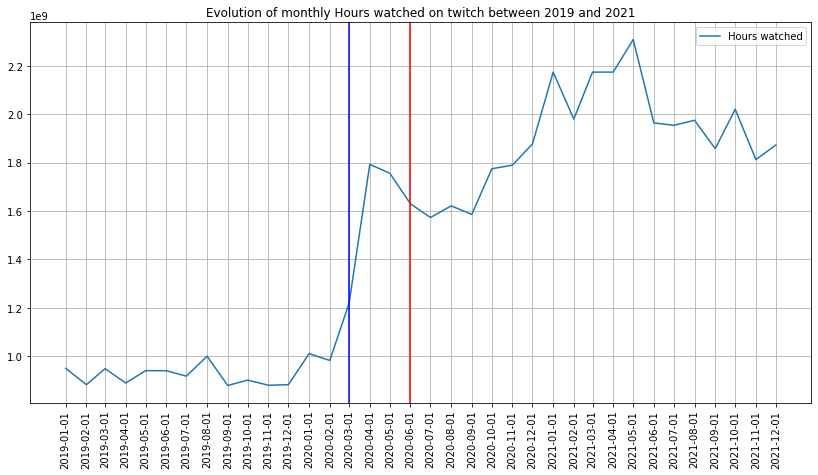

In [15]:
plt.figure(figsize=(14,7))
plt.plot(twitch_global.Date, twitch_global.Hours_watched, label="Hours watched")
plt.legend()
plt.grid()
plt.xticks(twitch_global.Date.dt.date,twitch_global.Date.dt.date, rotation='vertical')
plt.title("Evolution of monthly Hours watched on twitch between 2019 and 2021")
plt.axvline(x = pd.to_datetime("03/01/2020"), color = 'b', label = 'Start of lockdown')
plt.axvline(x = pd.to_datetime("06/01/2020"), color = 'r', label = 'End of lockdown')
plt.show()

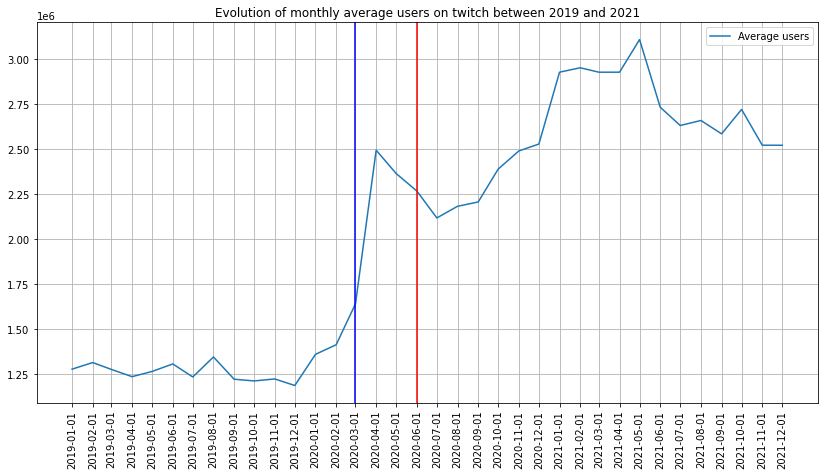

In [16]:
plt.figure(figsize=(14,7))
plt.plot(twitch_global.Date, twitch_global.Avg_viewers, label="Average users")
plt.legend()
plt.grid()
plt.xticks(twitch_global.Date.dt.date,twitch_global.Date.dt.date, rotation='vertical')
plt.title("Evolution of monthly average users on twitch between 2019 and 2021")
plt.axvline(x = pd.to_datetime("03/01/2020"), color = 'b', label = 'Start of lockdown')
plt.axvline(x = pd.to_datetime("06/01/2020"), color = 'r', label = 'End of lockdown')
plt.show()

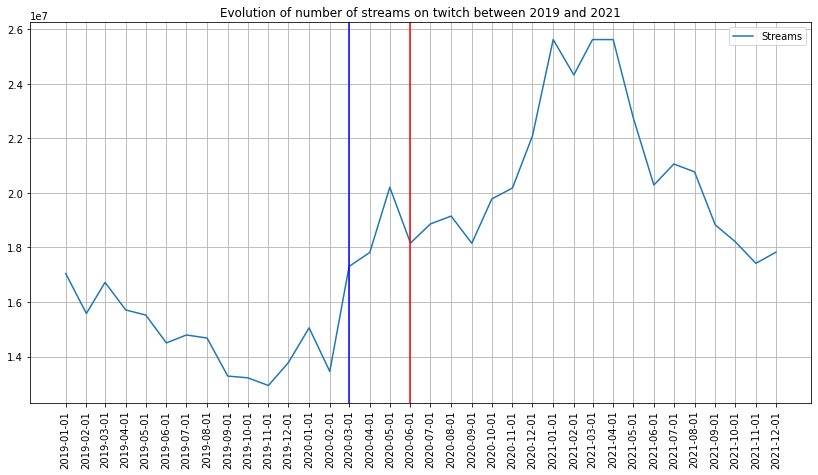

In [17]:
plt.figure(figsize=(14,7))
plt.plot(twitch_global.Date, twitch_global.Streams, label="Streams")
plt.legend()
plt.grid()
plt.xticks(twitch_global.Date.dt.date,twitch_global.Date.dt.date, rotation='vertical')
plt.title("Evolution of number of streams on twitch between 2019 and 2021")
plt.axvline(x = pd.to_datetime("03/01/2020"), color = 'b', label = 'Start of lockdown')
plt.axvline(x = pd.to_datetime("06/01/2020"), color = 'r', label = 'End of lockdown')
plt.show()

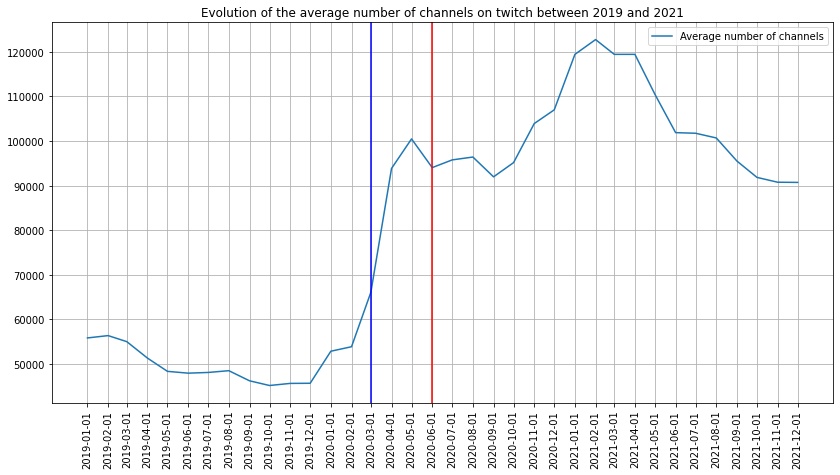

In [18]:
plt.figure(figsize=(14,7))
plt.plot(twitch_global.Date, twitch_global.Avg_channels, label="Average number of channels")
plt.legend()
plt.grid()
plt.xticks(twitch_global.Date.dt.date,twitch_global.Date.dt.date, rotation='vertical')
plt.title("Evolution of the average number of channels on twitch between 2019 and 2021")
plt.axvline(x = pd.to_datetime("03/01/2020"), color = 'b', label = 'Start of lockdown')
plt.axvline(x = pd.to_datetime("06/01/2020"), color = 'r', label = 'End of lockdown')
plt.show()

We notice a big increase in the watchtime, number of viewers, streams and channels of twitch during the lockdown hence showing a big interest in video games.

# Amazon top 50 best sellers books

In [19]:
# Compare the top 50 bestsellers on amazon per year until 2020. We will first look at the evolution of the number of reviews 
# (to see if more people started reading) before and during the lockdown, and then see if the genre of the books changed as well
# between fiction and non fiction
amazon_books = pd.read_csv("data/AmazonBooks - Sheet1.csv")

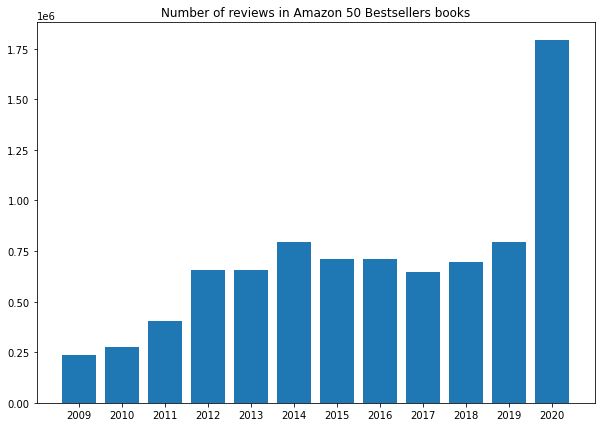

In [20]:
reviews = amazon_books.groupby("Year").sum()["Reviews"]
plt.figure(figsize=(10,7))
plt.bar(reviews.index,reviews)
plt.xticks(reviews.index)
plt.title("Number of reviews in Amazon 50 Bestsellers books")
plt.show()

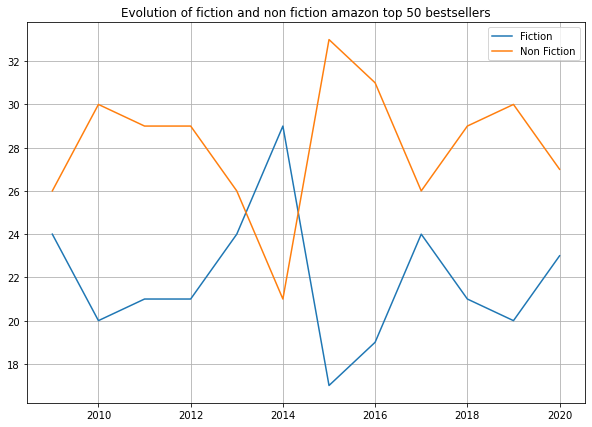

In [21]:
amazon_books=amazon_books.replace({'Non Fiction': 0, 'Fiction': 1})
genre = amazon_books.groupby("Year").sum()["Genre"]
plt.figure(figsize=(10,7))
plt.plot(genre.index, genre, label="Fiction")
plt.plot(genre.index, 50-genre, label="Non Fiction")
plt.legend()
plt.grid()
plt.title("Evolution of fiction and non fiction amazon top 50 bestsellers")
plt.show()

We can see a very big increase in the number of reviews for the top 50 books, suggesting that there was also a big increase in the number of sales, hence people started reading more in 2020. However, there doesn't seem to be any impact on the genre (fiction or non fiction). A dataset containing the exact genre of the books would have been better in that case.

# Global mobility report

In [22]:
# Using the global mobility report, we will look at the residential percent of people just before, during and after the lockdown
# for different countries compared to a 2019 baseline
zf = zipfile.ZipFile('data/Global_Mobility_Report.zip') 
global_mobility_report = pd.read_csv(zf.open("Global_Mobility_Report.csv"))

C:\Users\joena\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [23]:
# Keep only the whole countries data and not specific regions, look at residential_percent_change_from_baseline
global_mobility_report = global_mobility_report[global_mobility_report['sub_region_1'].isnull()]
global_mobility_report = global_mobility_report[["country_region", "date", "residential_percent_change_from_baseline"]]
global_mobility_report.head()

,country_region,date,residential_percent_change_from_baseline
0,United Arab Emirates,2020-02-15,1.0
1,United Arab Emirates,2020-02-16,1.0
2,United Arab Emirates,2020-02-17,1.0
3,United Arab Emirates,2020-02-18,1.0
4,United Arab Emirates,2020-02-19,1.0


In [24]:
# Place a xtick once every 10 days, otherwise too many and we cannot read the date
dates_mob = global_mobility_report[global_mobility_report["country_region"]=="Switzerland"]["date"]
d = dates_mob.tolist()
d = d[::10]

#Extract mobility for specific countries
switzerland = global_mobility_report[global_mobility_report["country_region"]=="Switzerland"]["residential_percent_change_from_baseline"]
usa = global_mobility_report[global_mobility_report["country_region"]=="United States"]["residential_percent_change_from_baseline"]
australia = global_mobility_report[global_mobility_report["country_region"]=="Australia"]["residential_percent_change_from_baseline"]
france = global_mobility_report[global_mobility_report["country_region"]=="France"]["residential_percent_change_from_baseline"]
germany = global_mobility_report[global_mobility_report["country_region"]=="Germany"]["residential_percent_change_from_baseline"]
italy = global_mobility_report[global_mobility_report["country_region"]=="Italy"]["residential_percent_change_from_baseline"]
spain = global_mobility_report[global_mobility_report["country_region"]=="Spain"]["residential_percent_change_from_baseline"]


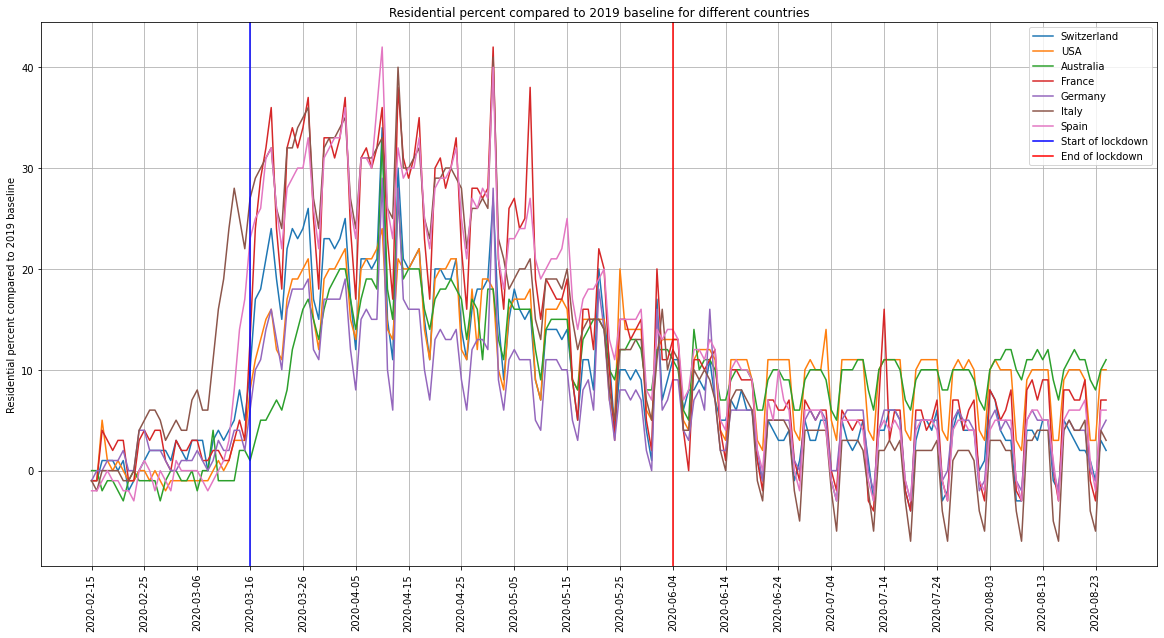

In [25]:
plt.figure(figsize=(20,10))
plt.plot(dates_mob, switzerland, label="Switzerland")
plt.plot(dates_mob, usa, label="USA")
plt.plot(dates_mob, australia, label="Australia")
plt.plot(dates_mob, france, label="France")
plt.plot(dates_mob, germany, label="Germany")
plt.plot(dates_mob, italy, label="Italy")
plt.plot(dates_mob, spain, label="Spain")
plt.xticks(d,d, rotation='vertical')
plt.axvline(x = 30, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 110, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Residential percent compared to 2019 baseline for different countries")
plt.ylabel("Residential percent compared to 2019 baseline")
plt.show()

As expected the number of people staying at home massively increased with the lockdown measures in place.

# Apps downloads

In [26]:
# We will compare the number of downloads of apps and games during 2019-2021 quarters to see if there is any difference due to
# the lockdown
apps_downloads = pd.read_csv("data/apps_downloads.csv")
apps_downloads.head()

,Date,Apps & Games,Apps,Game
0,Q1 2019,28.1,18.43,9.67
1,Q2 2019,28.7,18.24,10.46
2,Q3 2019,29.6,18.47,11.13
3,Q4 2019,28.7,17.78,10.92
4,Q1 2020,33.6,20.28,13.32


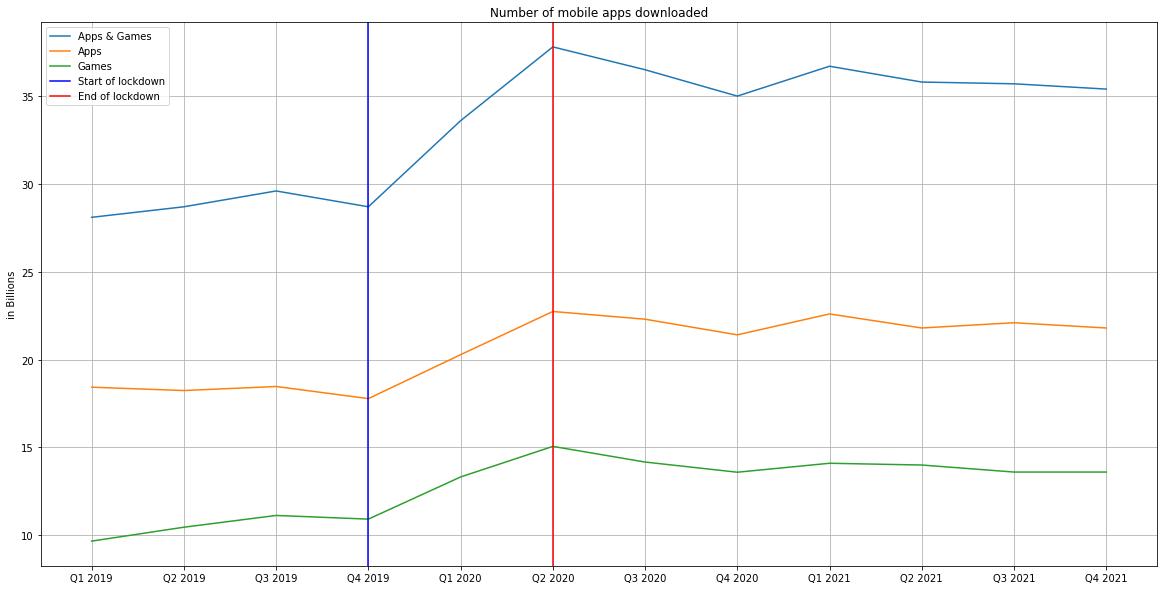

In [27]:
plt.figure(figsize=(20,10))
plt.plot(apps_downloads["Date"], apps_downloads["Apps & Games"], label="Apps & Games")
plt.plot(apps_downloads["Date"], apps_downloads["Apps"], label="Apps")
plt.plot(apps_downloads["Date"], apps_downloads["Game"], label="Games")
plt.axvline(x = 3, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 5, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Number of mobile apps downloaded")
plt.ylabel("in Billions")
plt.show()

We notice that the lockdown coincides perfectly with a boost of downloads of apps and games on smartphones.

# Wikipedia pageviews different topics

In [28]:
# Load datasets of wikipedia pageviews per subjects of interest. We will compare the evolution of visits of certain wikipedia
# pages for specific subjects before, during and after the lockdown
religion = pd.read_csv("data/religion.csv") 
social_media = pd.read_csv("data/social_media.csv")
video_games = pd.read_csv("data/video_games.csv")
board_games = pd.read_csv("data/board_games.csv")
streaming = pd.read_csv("data/streaming.csv")

dates = video_games["Date"]

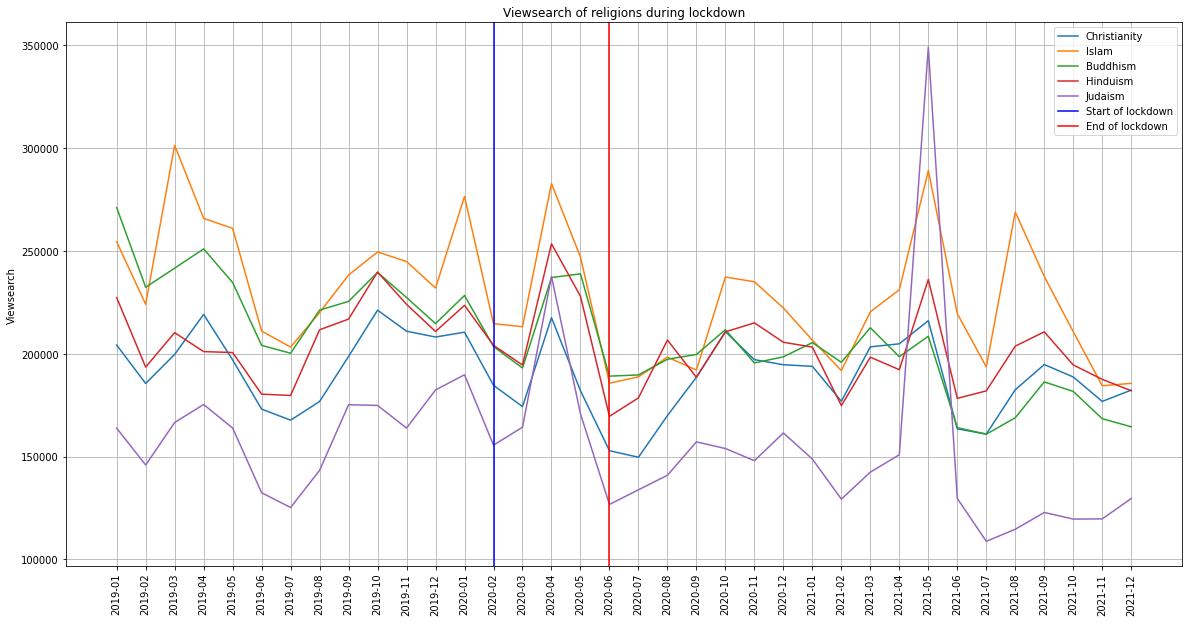

In [29]:
plt.figure(figsize=(20,10))
plt.plot(dates, religion["Christianity"], label="Christianity")
plt.plot(dates, religion["Islam"], label="Islam")
plt.plot(dates, religion["Buddhism"], label="Buddhism")
plt.plot(dates, religion["Hinduism"], label="Hinduism")
plt.plot(dates, religion["Judaism"], label="Judaism")
plt.tick_params(axis='x', labelrotation=90)
plt.axvline(x = 13, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 17, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Viewsearch of religions during lockdown")
plt.ylabel("Viewsearch")
plt.show()

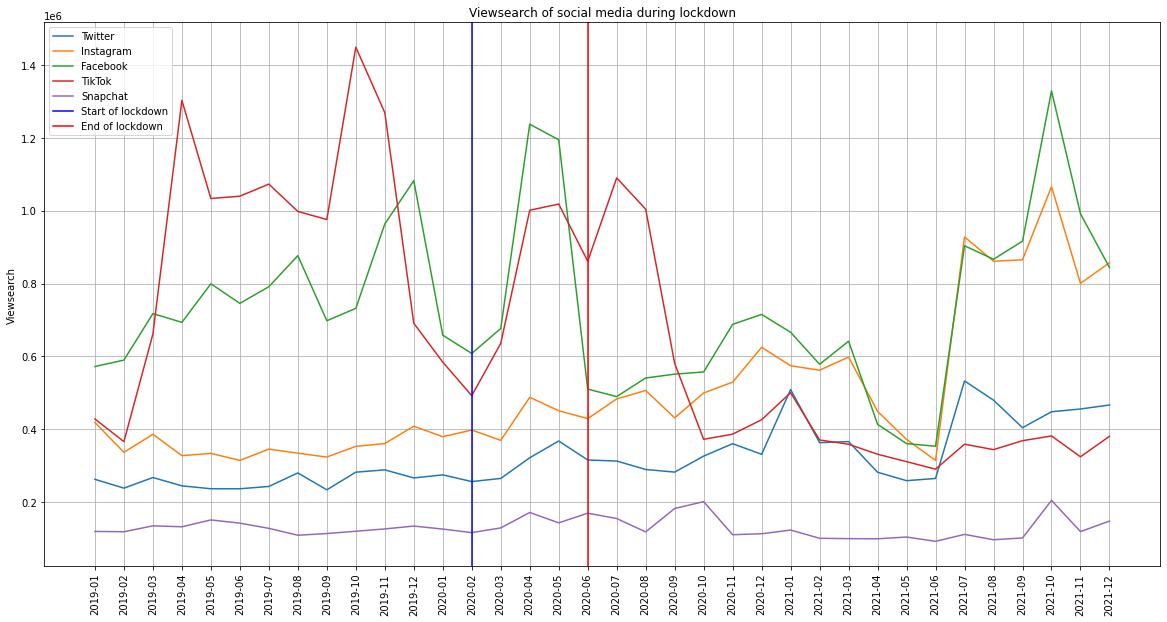

In [30]:
plt.figure(figsize=(20,10))
plt.plot(dates, social_media["Twitter"], label="Twitter")
plt.plot(dates, social_media["Instagram"], label="Instagram")
plt.plot(dates, social_media["Facebook"], label="Facebook")
plt.plot(dates, social_media["TikTok"], label="TikTok")
plt.plot(dates, social_media["Snapchat"], label="Snapchat")
plt.tick_params(axis='x', labelrotation=90)
plt.axvline(x = 13, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 17, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Viewsearch of social media during lockdown")
plt.ylabel("Viewsearch")
plt.show()

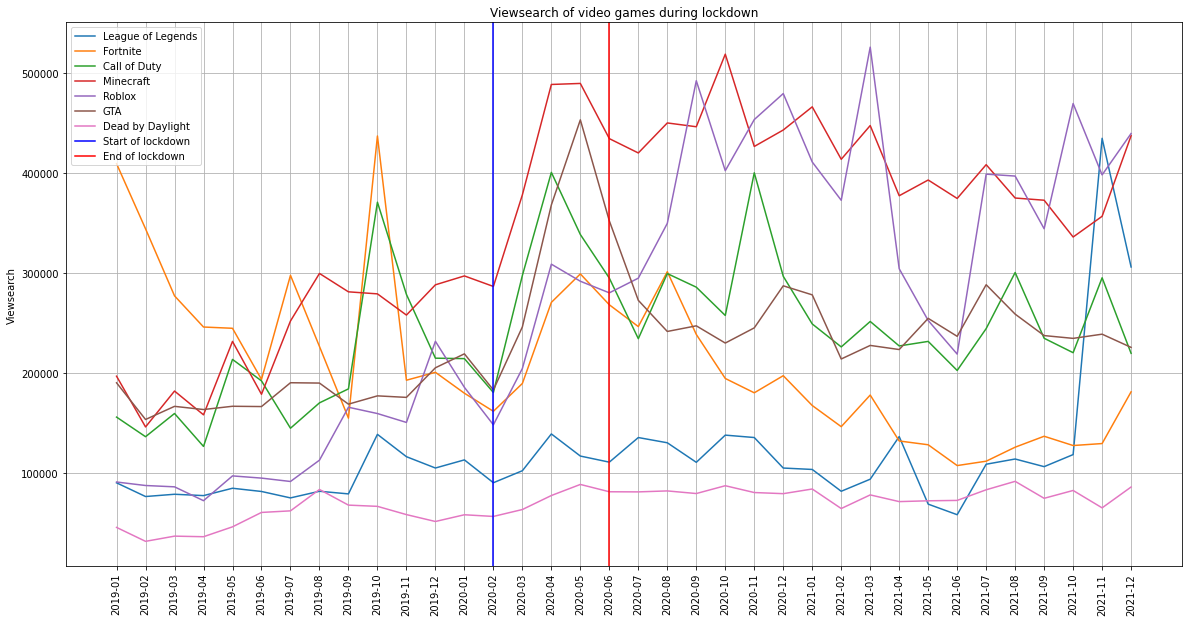

In [31]:
plt.figure(figsize=(20,10))
plt.plot(dates, video_games["League of Legends"], label="League of Legends")
plt.plot(dates, video_games["Fortnite"], label="Fortnite")
plt.plot(dates, video_games["Call of Duty"], label="Call of Duty")
plt.plot(dates, video_games["Minecraft"], label="Minecraft")
plt.plot(dates, video_games["Roblox"], label="Roblox")
plt.plot(dates, video_games["Grand Theft Auto V"], label="GTA")
plt.plot(dates, video_games["Dead by Daylight"], label="Dead by Daylight")
plt.tick_params(axis='x', labelrotation=90)
plt.axvline(x = 13, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 17, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Viewsearch of video games during lockdown")
plt.ylabel("Viewsearch")
plt.show()

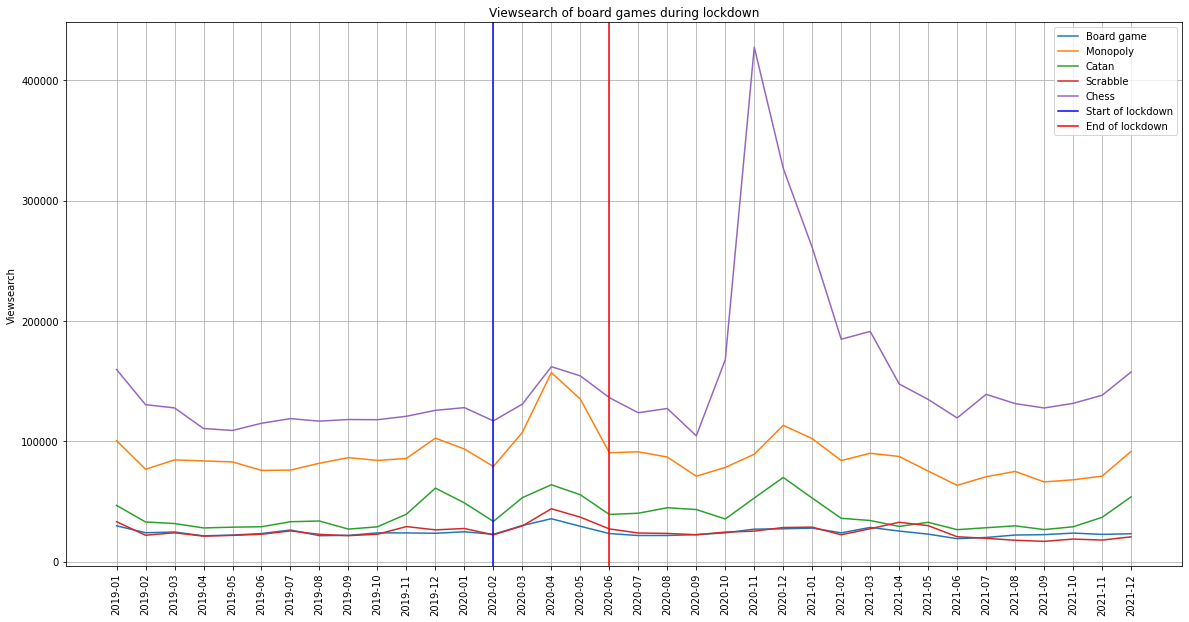

In [32]:
plt.figure(figsize=(20,10))
plt.plot(dates, board_games["Board game"], label="Board game")
plt.plot(dates, board_games["Monopoly (game)"], label="Monopoly")
plt.plot(dates, board_games["Catan"], label="Catan")
plt.plot(dates, board_games["Scrabble"], label="Scrabble")
plt.plot(dates, board_games["Chess"], label="Chess")
plt.tick_params(axis='x', labelrotation=90)
plt.axvline(x = 13, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 17, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Viewsearch of board games during lockdown")
plt.ylabel("Viewsearch")
plt.show()

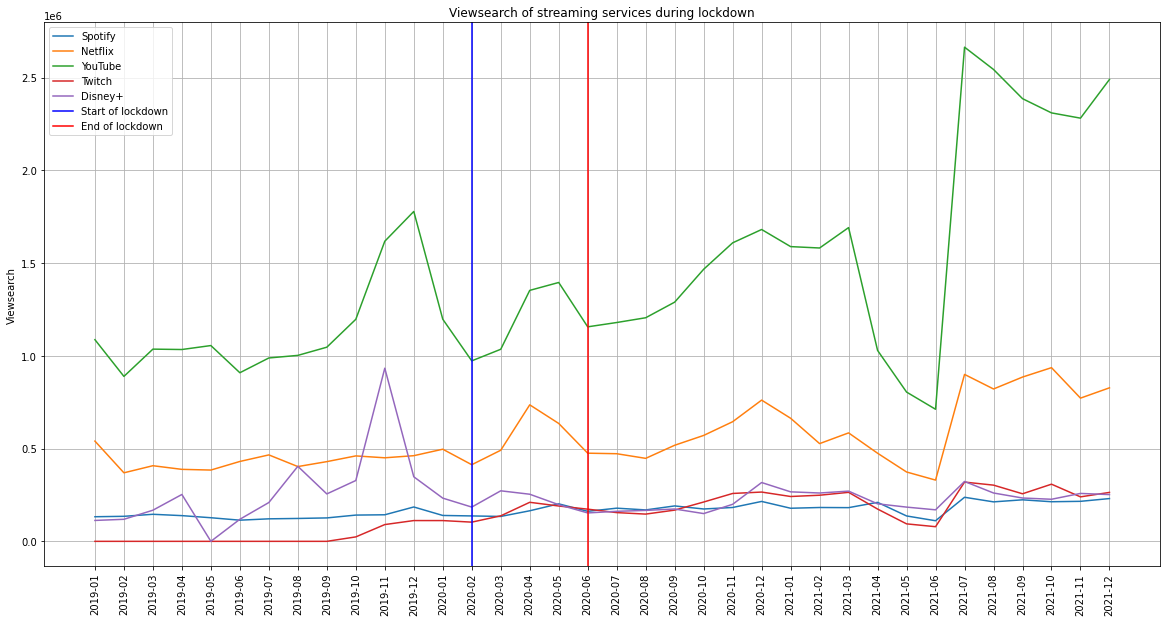

In [33]:
plt.figure(figsize=(20,10))
plt.plot(dates, streaming["Spotify"], label="Spotify")
plt.plot(dates, streaming["Netflix"], label="Netflix")
plt.plot(dates, streaming["YouTube"], label="YouTube")
plt.plot(dates, streaming["Twitch (service)"], label="Twitch")
plt.plot(dates, streaming["Disney+"], label="Disney+")
plt.tick_params(axis='x', labelrotation=90)
plt.axvline(x = 13, color = 'b', label = 'Start of lockdown')
plt.axvline(x = 17, color = 'r', label = 'End of lockdown')
plt.legend()
plt.grid()
plt.title("Viewsearch of streaming services during lockdown")
plt.ylabel("Viewsearch")
plt.show()

We notice that a lot more searches were done during the lockdown relative to certain topics an specially video games and board games.